In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git "pillow<7" ttach

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-r5nk4s13
  Running command git clone --filter=blob:none -q https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-r5nk4s13
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 61e9babae8600351b02b6e90864e4807f44f2d4a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [3]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
skills = dict(zip(skills.index, skills.values))

In [5]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
certs = dict(zip(certs.index, certs.values))

In [7]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [8]:
licenses = dict(zip(licenses.index, licenses.values))

In [9]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
languages = dict(zip(languages.index, languages.values))

In [11]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,90
84612,48
84731,3766
85437,3812
85627,1556


In [12]:
addresses = dict(zip(addresses.index, addresses.values))

In [13]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [14]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [15]:
df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()
df_pred["c"] = df_pred["candidate_id"]

In [16]:
# GRAD-cam requires a single input into forward(), so we need to include candidate in there as well
df_pred = df_pred[["candidate_id", "c", "time_between", "time_spent", "isco_functie_niveau", "source", "education", "company_name", "function_id", "isco_code4"]]

In [17]:
df_pred.head()

,candidate_id,c,time_between,time_spent,isco_functie_niveau,source,education,company_name,function_id,isco_code4
0,84556,84556,-0.292887,-0.210459,2.0,0,0.0,324258,936,208
1,84556,84556,-0.306568,-0.252626,1.0,0,0.0,324258,809,348
2,84556,84556,-0.306568,-0.085012,2.0,0,0.0,329244,936,208
3,84556,84556,0.799670,-0.370694,1.0,0,0.0,368140,1519,344
4,84556,84556,-0.130664,-0.363314,1.0,0,0.0,419826,1519,344


In [18]:
majority_class = df_pred["isco_code4"].mode().values[0]

In [19]:
features = df_pred.columns[1:]

In [20]:
career_paths = df_pred.groupby("candidate_id")

In [21]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 9)

In [22]:
maximum_career_duration = 25

In [23]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:45<00:00, 10321.13it/s]


In [24]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [25]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [26]:
career_paths.head()

candidate_id
84556    [[84556.0, -0.292886688151019, -0.210458701020...
84612    [[84612.0, 2.150219165944193, -0.3685852264755...
84731    [[84731.0, -0.28409150707627623, -0.3506642202...
85437    [[85437.0, 0.4009553744120213, 0.3313881928721...
85888    [[85888.0, -0.23816111701928622, -0.2895219637...
dtype: object

In [27]:
idxs = []
x = []
y = []

candidate_lens = defaultdict(int)

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):
        candidate_lens[idx] = len(career) - 1
        
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [28]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [29]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [30]:
del df_pred
del x
del career_paths

In [31]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [32]:
len(to_fill), len(y)

(113724, 113724)

In [33]:
# to_fill = to_fill[:25000]
# y = y[:25000]

In [34]:
# Train test split
split = 0.8
random.seed(42)

training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
test = np.array(list(set(range(len(to_fill))) - set(training)))

train_indices, val_indices = idxs[training], idxs[test]
X_train, X_val = to_fill[training], to_fill[test]
y_train, y_val = y[training].astype(int), y[test].astype(int)

In [35]:
# Class weights
counts = np.bincount(y_train) + 1

# TODO: Change so that common classes get punished slightly more
labels_weights = 2. / (0.5 * np.sqrt(counts))
weights = labels_weights[y_train]
sampler = WeightedRandomSampler(weights, len(weights))

# Create dataloaders
train_data = TensorDataset(torch.Tensor(train_indices), 
                           torch.Tensor(X_train), 
                           torch.Tensor(y_train).type(torch.LongTensor))

trainloader = DataLoader(train_data, batch_size=512, sampler=sampler)

val_data = TensorDataset(torch.Tensor(val_indices),
                         torch.Tensor(X_val),
                         torch.Tensor(y_val).type(torch.LongTensor))

valloader = DataLoader(val_data, batch_size=512, shuffle=True)

In [36]:
# # Feature maps per time step
# # N = features (each feature is a 'time series' in the words of the authors), T = time steps

# k1 = 25
# f_maps = 100
# N = 9

# conv2d = nn.Conv2d(in_channels=1,
#                    out_channels=f_maps,
#                    kernel_size=(1, k1),
#                    stride=(1, 2),
#                    padding=(0, k1 // 2))

# _1x1 = nn.Conv2d(in_channels=f_maps, 
#                  out_channels=1, 
#                  kernel_size=(1, 1), # Maybe (100, 1, 1)?
#                  stride=1)

# # Feature map for all features
# # 84 = n_features
# conv1d = nn.Conv1d(in_channels=1,
#                    out_channels=1, 
#                    kernel_size=(N, k1 // 2),
#                    padding=(N // 2, k1 // 2 // 2 // 2)) # lol

# for c, i, j in trainloader:
    
#     i = i.unsqueeze(-1)
#     i = i.transpose(1, 3)
#     print(i.shape)
#     x = conv2d(i) 
#     print(x.shape)
#     x = _1x1(x)
#     print(x.shape)
#     x = conv1d(x)
    
#     x = x.flatten(start_dim=1)
    
#     print(x.shape)
    
#     break

In [50]:
class CNN(nn.Module):

    def __init__(self, num_classes, input_size, skills, certs, licenses, 
                 languages, addresses, w2v, candidate_lengths, max_len, 
                 f_maps=32, f_maps2=64, skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(CNN, self).__init__()
              
        self.num_classes = num_classes
        self.input_size = input_size + 300
        self.conv_size = conv_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4757, address_embedding_size)       
        
        # Categorical feature embeddings
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.source_embedding = nn.Embedding(2, 1)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
                
        # -6 --> embedded features get replaced
        N = self.input_size - 6 + skill_embedding_size + certs_embedding_size + \
            license_embedding_size + language_embedding_size + address_embedding_size + \
            function_embedding_size + isco4_embedding_size + company_embedding_size + \
            education_embedding_size + isco_level_embedding_size
        
        # Actual model
        k1 = 8
        k2 = 6
        
        self.relu = nn.ReLU()
        
        # TODO: more than 1 conv2d
        self.conv2d = nn.Conv2d(in_channels=1,
                                out_channels=f_maps,
                                kernel_size=(k1, 1),
                                stride=(2, 1),
                                padding=(k1 // 2, 1 // 2))
        
        self.conv2d2 = nn.Conv2d(in_channels=f_maps,
                                 out_channels=f_maps2,
                                 kernel_size=(k2, 1),
                                 stride=(2, 1),
                                 padding=(k2 // 2, 1 // 2))
        
        self._1x1 = nn.Conv2d(in_channels=f_maps2, 
                              out_channels=1, 
                              kernel_size=(1, 1), # Maybe (100, 1, 1)?
                              stride=1)

        self.conv1d = nn.Conv1d(in_channels=1,
                                out_channels=1, 
                                kernel_size=(k1, N),
                                stride=2,
                                padding=(k1 // 2, N // 2))
        
        self.dropout = nn.Dropout(p=0.4)
        
        self.fc = nn.Linear(1904, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        
        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])   
                
    
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= self.max_len])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()
                if durations[-1] == -1: # Sometimes contains -1 --> last location > (career duration)?
                    durations.pop()
                    durations[-1] -= 1
                    # In case the last one should be ignored completely
                    if durations[-1] == 0:
                        durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        try:
                            storage.append(torch.stack([torch.Tensor(embed_values[i])] * duration, dim=0))
                        except:
                            print(duration, embed_values[i])
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
    
    def create_tensor(self, x):
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 408).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        # Extract candidate_ids
        candidate = x[:,:,0][:,-1].cpu()
        
        # Everything else stays in x
        x = x[:,:,1:]
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]

        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
            
            # Error due to filtering
            if career_duration == 0:
                career_duration += 1
            
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))                
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                        
            # Broadcast and add static features
            static_features = torch.stack([batch_features[i]] * career_duration).type(torch.LongTensor).to(device)
            address_emb = torch.stack([batch_addresses[i]] * career_duration).type(torch.LongTensor).to(device)
            
            # Combine w2v, static features, and address
            full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, full_features], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
        
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, source, education, company_name, function_id, isco_code = [x[:,:,-6],
                                                                               x[:,:,-5],
                                                                               x[:,:,-4],
                                                                               x[:,:,-3],
                                                                               x[:,:,-2],
                                                                               x[:,:,-1]]
        
        x = x[:,:,:-6].to(device)

        isco_level, source, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)),
                                                                                self.source_embedding(source.type(torch.LongTensor).to(device)),
                                                                                self.education_embedding(education.type(torch.LongTensor).to(device)),
                                                                                self.company_embedding(company_name.type(torch.LongTensor).to(device)),
                                                                                self.function_embedding(function_id.type(torch.LongTensor).to(device)),
                                                                                self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device))]
                
        # Add features
        x = torch.cat([x, isco_level, source, education, company_name, function_id, isco_code, additional_features], dim=2)
        
        return x
        
 
    def forward(self, x):               
        # x = self.create_tensor(x)
        
        # Reshape to allow conv2D
        x = x.unsqueeze(-1)
        x = x.transpose(1, 3)
        x = x.transpose(2, 3)
        
               
        # Stage 1:
        # K time steps, 1 feature at a time
        x = self.conv2d(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # print(x.shape)
        
        # x = self.conv2d2(x)
        # x = self.stage1(x)
        
#         print(x.shape)
                
        # Reduce to 1 feature map
        x = self._1x1(x)       
        
#         print(x.shape)
        
        # Stage 2:        
        # Patterns across all features
        x = self.conv1d(x)
        # x = self.stage2(x)
        # x = self.dropout(x)   
        
#         print(x.shape)
                
        # Predict
        x = x.transpose(2, 3)

        x = x.flatten(start_dim=1)               
        out = self.fc(x)
        # out = self.relu(x)
               
        # softmax
        out = self.softmax(out)                        
        return out

In [51]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            optimizer.zero_grad()
            
            career = model.create_tensor(career)
            outputs = model(career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
               
        training_loss /= len(trainloader)
                
        stats = test_loop(valloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")
        
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)

        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            
            career = model.create_tensor(career)
            pred = model(career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
#         a = weights[0].cpu().detach().numpy().mean(axis=0)            
#         plt.plot(a, label="average")
#         plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
#         plt.xlabel("Career step")
#         plt.ylabel("Attention weight")
#         plt.show()
 
            
    # print("\nValidation:", Counter(np.array(pred.argmax(1).cpu())))
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [52]:
torch.cuda.empty_cache()

In [53]:
sns.set_style("white")

Current iteration 0/18
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2992, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (conv2d): Conv2d(1, 32, kernel_size=(8, 1), stride=(2, 1), padding=(4, 0))
  (conv2d2): Conv2d(32, 32, kernel_size=(6, 1), stride=(2, 1), padding=(3, 0))
  (_1x1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv1d): Conv1d(1, 1, kernel_size=(8, 542), stride=(2,), padding=(4, 271))
  (dropout): Dropout(p=0.4

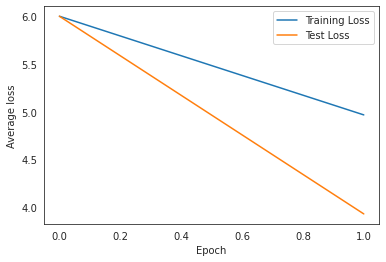

In [54]:
num_epochs = 1
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4][2:]
num_layers_values = [1, 5, 10]
conv_sizes = [16, 32, 64, 128][1:]
conv_size2 = 32

skill_embedding_size=50
certs_embedding_size=20
license_embedding_size=3
language_embedding_size=10
address_embedding_size=25
function_embedding_size=50 
isco4_embedding_size=25
education_embedding_size=3
isco_level_embedding_size=3
company_embedding_size=50

try:            
    for learning_rate in learning_rates:
        for conv_size in conv_sizes:

            cnn = CNN(num_classes=num_classes,
                      input_size=num_features,
                      f_maps=conv_size,
                      f_maps2=conv_size2,
                      skills=skills, 
                      certs=certs,
                      licenses=licenses,
                      languages=languages,
                      addresses=addresses,
                      w2v=w2v,
                      address_embedding_size=25,
                      candidate_lengths=candidate_lens,
                      max_len=max_len)

            cnn = cnn.to(device)

            optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

            print(f"Current iteration {current}/{len(learning_rates) * len(num_layers_values) * len(conv_sizes)}")
            print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", cnn, "\n")

            # Store results of current configuration
            outcome = train_loop(cnn, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
            outcome["lr"] = [learning_rate] * num_epochs
            outcome["Convolution size"] = [conv_size] * num_epochs

            full_results.append(outcome)

            current += 1
            
            break

        # We ignore LR for now
        break
except KeyboardInterrupt:
    pass

In [55]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Convolution size", "Epoch"])

In [56]:
total

,,,Acc@1,Acc@5,Acc@10,Acc@20,test_loss,training_loss,duration
lr,Convolution size,Epoch,,,,,,,
0.001,32,1,0.161838,0.457024,0.591647,0.723192,3.93178,4.967748,247


Batch accuracy: 0.173828125

Majority class accuracy: 0.140625
Majority class predictions: 0.193359375


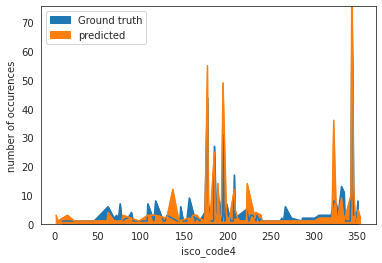

In [57]:
with torch.no_grad():
    for candidate, career, job in valloader:
        candidate, career, job = candidate.to(device), career.to(device), job.to(device)
        
        career = cnn.create_tensor(career)
        pred = cnn(career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())    
        print()

        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())        
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        
        plt.show()        
        break

In [59]:
del skills
del certs
del w2v
del languages
del to_fill

In [58]:
# x, isco_level, source, education, company_name, function_id, isco_code, w2v_list, skill_list, certs_list, license_list, langs_list, address_emb
feature_names = ["Time spent", "Time between", "isco level", "source",
                 "education", "company name", "function", "isco code",
                 "cv", "skills", "certificates", "licenses", "languages", "location"]

# skill_embedding_size=50, certs_embedding_size=20,
# license_embedding_size=3, language_embedding_size=10,
# address_embedding_size=25, function_embedding_size=50, 
# isco4_embedding_size=25, education_embedding_size=3, 
# isco_level_embedding_size=3, company_embedding_size=50
source_embedding_size = 1
w2v_embedding_size = 300

embedding_sizes= [0, 1, 2, isco_level_embedding_size, source_embedding_size,
                  education_embedding_size, company_embedding_size, function_embedding_size, 
                  isco4_embedding_size, w2v_embedding_size, skill_embedding_size, certs_embedding_size, 
                  license_embedding_size, language_embedding_size, address_embedding_size]

In [59]:
def merge_layers(output, embedding_sizes):
    """order: start=0, reg_features, isco_level_embedding_size, source_embedding_size, 
              education_embedding_size, company_embedding_size, function_embedding_size, 
              isco4_embedding_size, w2v_embedding_size, skill_embedding_size, 
              certs_embedding_size, license_embedding_size, language_embedding_size, 
              address_embedding_size"""
    
    idxs = np.cumsum(embedding_sizes)
        
    result = np.stack([output[idxs[i]:idxs[i+1]].mean(axis=0) for i in range(len(idxs) - 1)])
    
    return result

In [74]:
def apply_grad_cam(model, target_layer, dataloader, single_batch=False, single_user=False):
    
    if target_layer == 1:
        target_layer = [cnn.conv2d2]
        sum_axis = 2
        to_transpose = False
    elif target_layer == 2:
        target_layer = [cnn.conv1d]
        sum_axis = 0
        to_transpose = True
        
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True)
    
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    
    overall = []

    for c, i, j in tqdm(dataloader):
        c, i, j = c.to(device), i.to(device), j.to(device)
        
        
        if single_user:
            i = i[0]
            i = i.unsqueeze(0)
            i = cnn.create_tensor(i)
            a = cam(input_tensor=i[0].unsqueeze(0))
            a = a.mean(axis=sum_axis)
                        
            if to_transpose:
                a = a.T
            
            overall.append(a)
            break
            
        elif single_batch:
            i = cnn.create_tensor(i)
            a = cam(input_tensor=i)
            a = a.mean(axis=sum_axis)
            
            if to_transpose:
                a = a.T
            
            overall.append(a)
            break
            
        else:
            i = cnn.create_tensor(i)
            a = cam(input_tensor=i)
            a = a.mean(axis=sum_axis)
            
            if to_transpose:
                a = a.T

            overall.append(a)
            
    # Take mean over entire batch
    overall = np.array(overall).mean(axis=0)
    
    # Merge features
    to_plot = merge_layers(overall, embedding_sizes)

    # Plot
    plt.figure(figsize=(16, 6))
    sns.heatmap(to_plot, cmap=cmap, xticklabels=range(1, 26), yticklabels=feature_names)
    
    return cam

In [ ]:
cam = apply_grad_cam(cnn, 1, valloader, single_user=True)

  0%|          | 0/45 [00:02<?, ?it/s]


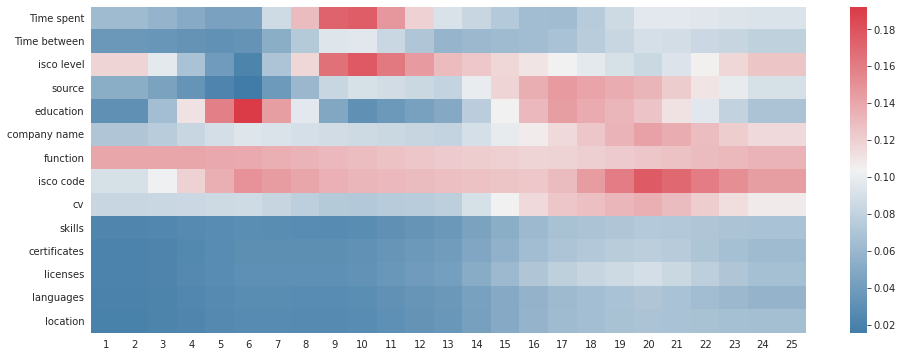

In [78]:
cam2 = apply_grad_cam(cnn, 2, valloader, single_batch = True)

100%|██████████| 45/45 [01:36<00:00,  2.13s/it]


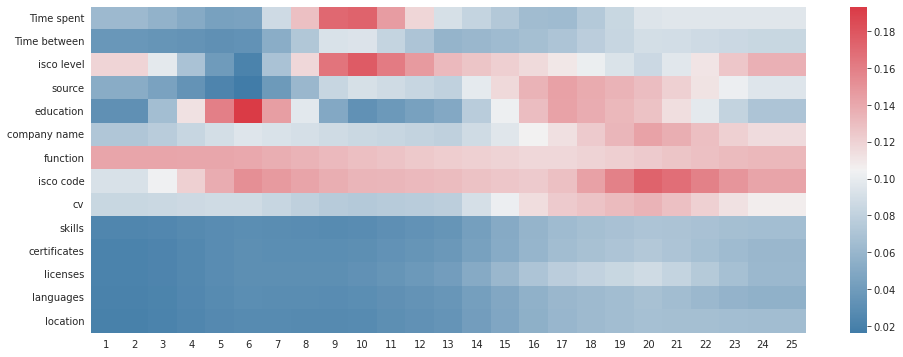

In [79]:
apply_grad_cam(cnn, 2, valloader)